# **DIABETIC RETINOPATHY DETECTION**

### This project uses the following notebooks used to create the models detecting the retina disease in diabetic patients.

1. 1_CNN_Model_Baseline.ipynb - testing on small subset of images across 5 different stages
2. 2_CNN_Model.ipynb - binary classification of final dataset, created baseline and second iteration 
3. 3_TL_MobileNet_Model.ipynb (current) - binary classification of final dataset using transfer learning with MobileNet V2 model
4. 4_Yolov5_Model.ipynb - further experimentation to detect multiclassification on different stages of diabetic retinopathy as next steps.



### 3_TL_MobileNet_Model (current) - Using a pretrained model MobileNet V2 and transfer learning with fine tuning.

MobileNetV2 is developed by Google, pretrained on ImageNet dataset consisting of 1.4 m images and 1000 classes. 
We will use 2 ways to customize a pretrained models:
1. Feature extraction: using the representations learned by previous model, extract meaningful features. Use the feature maps and train with a new classifier on top
2. Fine Tuning: Unfreeze a few of the top layers of a frozen model base model and join with new classifier layers and last layers of base model, fine tuning higher order feature representations


## 1. Imports and Mount Drive

Mount the content drive and use the relevant imports for tensorflow and keras preprocessing.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## 2. Data Pre-Processing

We will use the train dataset consisting of 2 classes - 0 being healthy image dataset and 1 being diabetic retinopathic eye. Create a train and validation dataset that are pre-labeled and sticking to image size of (244, 244)

In [20]:
#gather the data folders located on the drive, both with labeled 0 and 1 images.
PATH = '/content/drive/MyDrive/Colab Notebooks/Capstone/'
train_dir = os.path.join(PATH, 'binary_train/')
validation_dir = os.path.join(PATH, 'binary_val/')

BATCH_SIZE = 32
IMG_SIZE = (244, 244)

train_dataset = image_dataset_from_directory(train_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 10217 files belonging to 2 classes.
Found 892 files belonging to 2 classes.


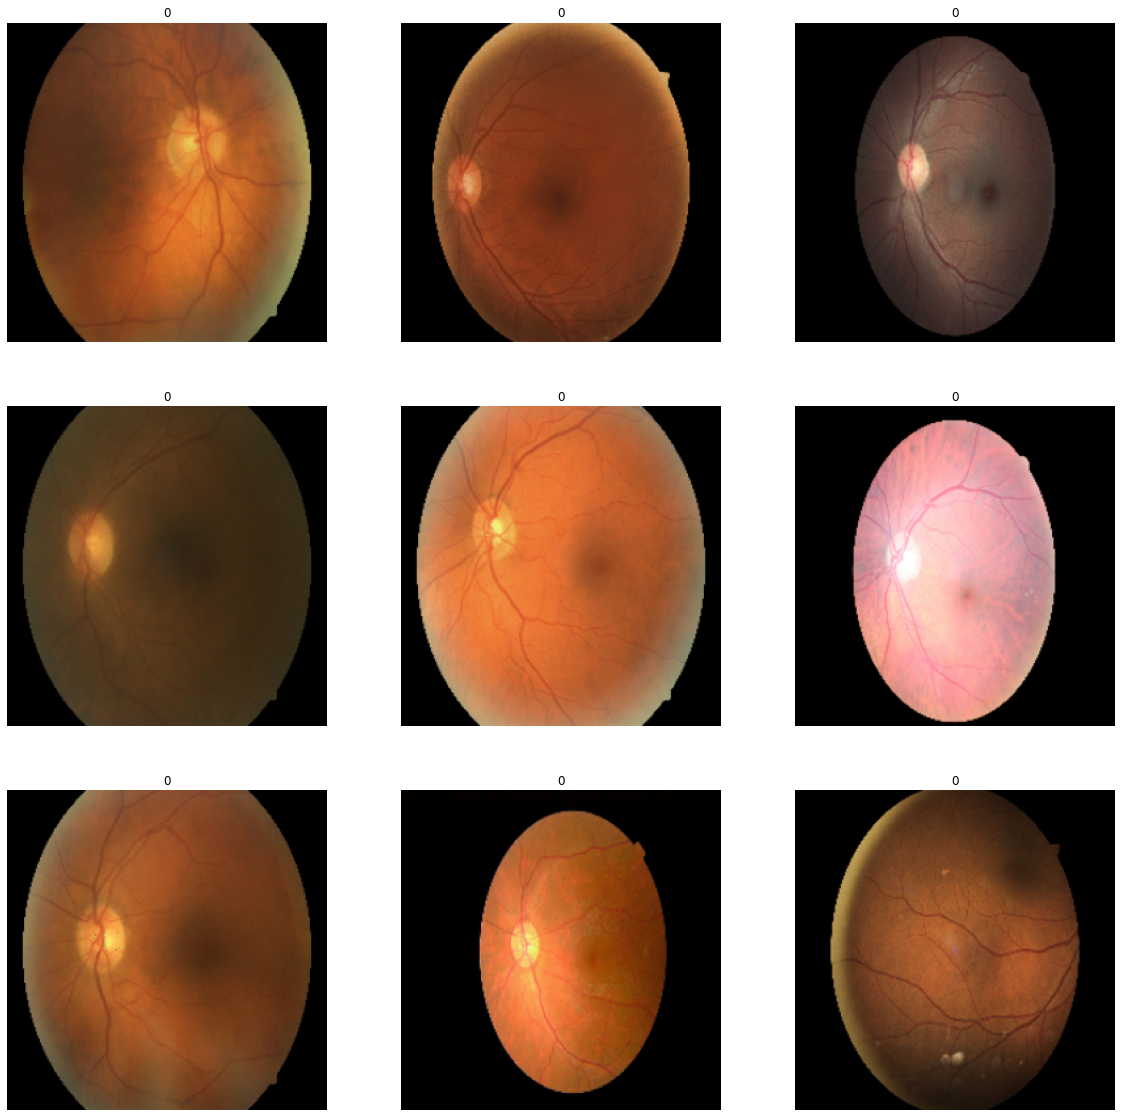

In [22]:
#print out images from the dataset for both classes for display
class_names = train_dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [23]:
#to get few test images, moving 20% from validation to test using experimental.cardinality
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [24]:
#printing the total validation and test batches
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 23
Number of test batches: 5


## 3. Configure the dataset for performance

Use buffered prefetching to lead images from having I/O blocking

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 4. Use data augmentation

When we dont have a large dataset, its a good practice to artificially increase the datset by adding diversity of applying random, rotation and contract. This helps the model to different aspects of the training data and reduce overfitting.

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.15, 0.15)
])

Let us look at few augmented images for both the classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


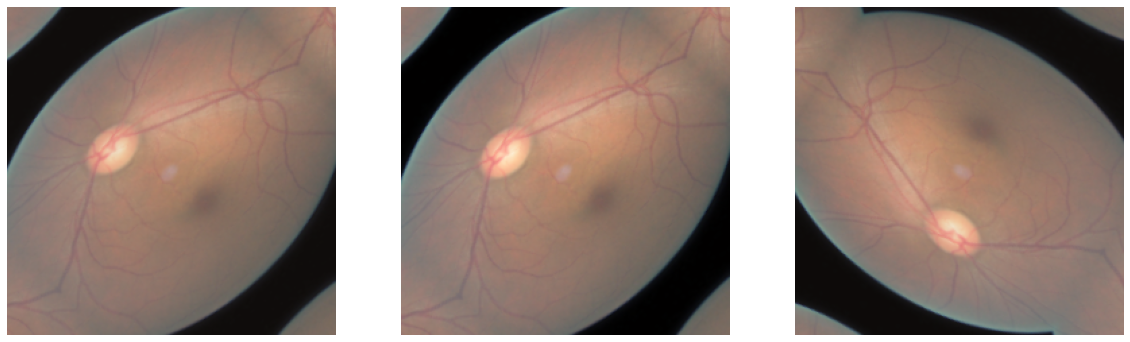

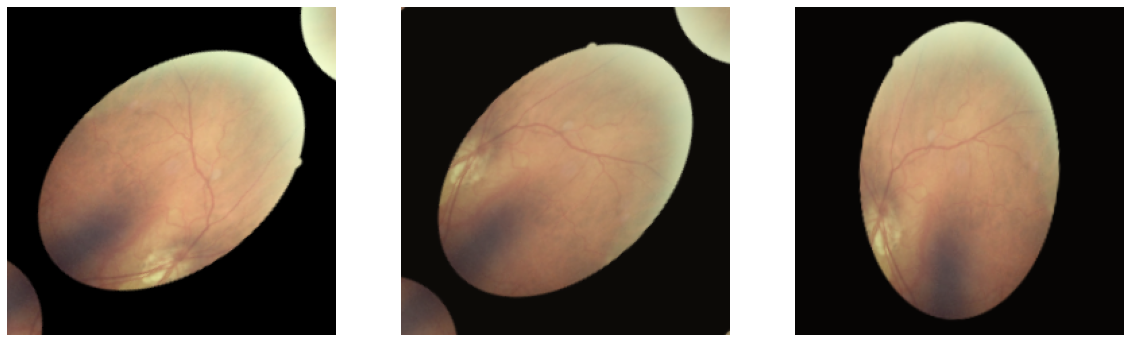

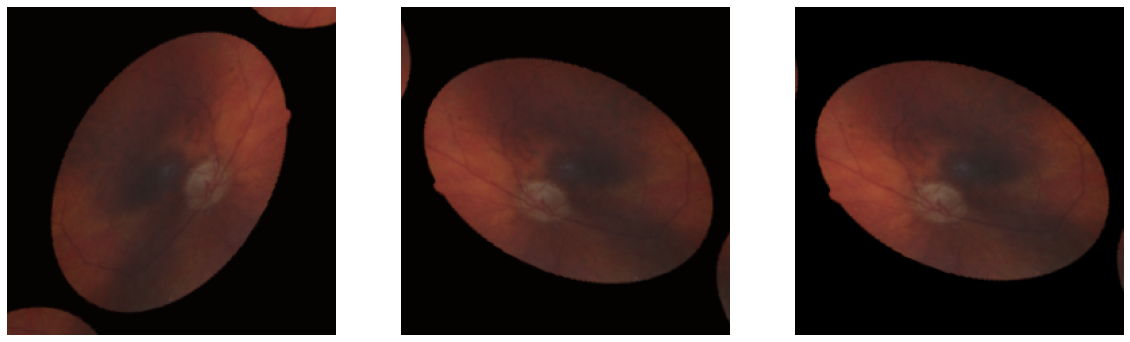

In [27]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(20, 20))
  first_image = image[0]
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

for image, _ in train_dataset.take(2):
  plt.figure(figsize=(20, 20))
  first_image = image[0]
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## 5. Rescaling

To use the base model MobileNetv2, the model expects rescaled images in range [-1,1], since our images are in 0-255, we need to apply rescale.

In [28]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [29]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## 6. Create the base model from pretrained MobileNet V2

Instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. 
Include_top = False indicates the model not to include the classfication layers at the top to allow feature extraction.

In [30]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


This feature extractor converts 244x244x3 image into a 8x8x1280 block of features.

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


## 7. Feature Extraction

In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you can add a classifier on top and train the top layer classifier.

### Freeze the convolutional base

Freeze the convolutional base before you compile and train the model. Freezing (by setting layer trainable = False) prevents the weights in a given layer from being updated during training.

MobileNetV2 has many layers, so setting the entire model trainable flag to false will freeze all of them.

In [32]:
base_model.trainable = False

### BatchNormalization layers

Many models contain tf.keras.layers.BatchNormalization layers. During the freeze, the BatchNormalization layer will run in inference mode.

When model is unfrozen, during fine tuning, the BatchNormalization layers must be run in inference mode by passing training = False. Otherwise, the updates to non-trainable weights will destroy what the model has learned.

In [33]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 122, 122, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 122, 122, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 122, 122, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 locations, using a tf.keras.layers.GlobalAveragePooling2d layer to convert features to a single 1280 element vector per image.


In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a keras.layer.Dense layer to convert these features into a single prediction per image. We do not need activation function because the prediction will be treated as a logit, a raw prediction value.

In [35]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining the data augmentation, rescaling, base_model and feature extractor layers using Keras Functional API.

In [36]:
inputs = tf.keras.Input(shape=(244, 244, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Copile the model before training it. Since there are two classes, use a binary cros-entropy loss with from_logits=True since the model provides a linear output.

In [37]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 244, 244, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 244, 244, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 244, 244, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.25M parameters in MobileNet are frozen, but there are 1.2k trainable parameters in the Dense layer. These are divided between 2 objects, the weights and biases.

In [39]:
len(model.trainable_variables)

2

### Train the model

Even though initial accuracy shows 0.66 before the model has been fit, The model is ready to fit for 20 epochs and 320 steps for each epoch.

In [40]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

23/23 [==============================] - 404s 9s/step - loss: 0.7266 - accuracy: 0.6379


In [41]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.66


In [42]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
320/320 [==============================] - 4324s 14s/step - loss: 0.4131 - accuracy: 0.8613 - val_loss: 0.6477 - val_accuracy: 0.7350
Epoch 2/20
320/320 [==============================] - 36s 109ms/step - loss: 0.3699 - accuracy: 0.8661 - val_loss: 0.6006 - val_accuracy: 0.7295
Epoch 3/20
320/320 [==============================] - 36s 110ms/step - loss: 0.3515 - accuracy: 0.8683 - val_loss: 0.5709 - val_accuracy: 0.7350
Epoch 4/20
320/320 [==============================] - 36s 111ms/step - loss: 0.3380 - accuracy: 0.8693 - val_loss: 0.5406 - val_accuracy: 0.7391
Epoch 5/20
320/320 [==============================] - 36s 109ms/step - loss: 0.3311 - accuracy: 0.8712 - val_loss: 0.5273 - val_accuracy: 0.7404
Epoch 6/20
320/320 [==============================] - 36s 109ms/step - loss: 0.3267 - accuracy: 0.8721 - val_loss: 0.5192 - val_accuracy: 0.7459
Epoch 7/20
320/320 [==============================] - 36s 111ms/step - loss: 0.3212 - accuracy: 0.8756 - val_loss: 0.5058 - val_ac

### Validating plots for Accuracy and Loss

Below are the plots for training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

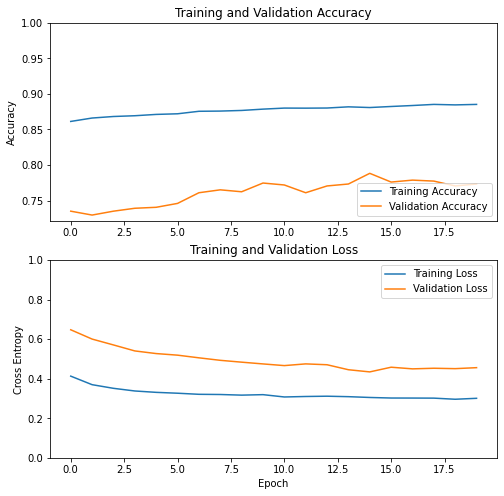

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [44]:
loss1, accuracy1 = model.evaluate(test_dataset)
print("base model loss: {:.2f}".format(loss1))
print("base model accuracy: {:.2f}".format(accuracy1))

5/5 [==============================] - 1s 107ms/step - loss: 0.4197 - accuracy: 0.8062
base model loss: 0.42
base model accuracy: 0.81


We can see that BstchNormalization and Dropout affect accuracy during training. 

Training accuracy is at 88%
Validation accuracy is at 81% 

## 8. Fine Tuning 

In feature extraction, thr training was performed on a few layers on top of the MobileNetV2 base model. 
The weights of the pre-trained network were not updated during training.

Fine tuning - The training prcess will force the weights to be tuned from generic feature maps to features associated with the dataset.

As we go higher, the features are more specific, the goal of fine tuning is to adapt these specialized features to work with the new dataset, rather than overwriting the generic learning.

### Unfreeze the top layers

Unfreeze the base_model and set the bottom layers to be un-trainable. Recompile and resume training for additional epochs.

For this project, fine tuning layer is at 100, it will train on 54 layers on top.

In [45]:
base_model.trainable = True

In [46]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As we are training a much larger model and want to readapt the pretrained weigths, it is important to use lower learning rate to avoid overfitting.

In [47]:
# compile model
model.compile( loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 244, 244, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 244, 244, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 244, 244, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [49]:
len(model.trainable_variables)

56

### Continue training the model

Used 30 epochs to run the fine tuning model. The first itertaion showed an accuracy of 90%, second iteration showed an accuracy of 94%.

In [50]:

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/70
320/320 [==============================] - 40s 109ms/step - loss: 0.3060 - accuracy: 0.8841 - val_loss: 0.3982 - val_accuracy: 0.8210
Epoch 21/70
320/320 [==============================] - 35s 108ms/step - loss: 0.2802 - accuracy: 0.8946 - val_loss: 0.3174 - val_accuracy: 0.8593
Epoch 22/70
320/320 [==============================] - 35s 108ms/step - loss: 0.2695 - accuracy: 0.8979 - val_loss: 0.3856 - val_accuracy: 0.8306
Epoch 23/70
320/320 [==============================] - 36s 109ms/step - loss: 0.2567 - accuracy: 0.9042 - val_loss: 0.4129 - val_accuracy: 0.8183
Epoch 24/70
320/320 [==============================] - 36s 109ms/step - loss: 0.2454 - accuracy: 0.9066 - val_loss: 0.3022 - val_accuracy: 0.8566
Epoch 25/70
320/320 [==============================] - 36s 111ms/step - loss: 0.2374 - accuracy: 0.9082 - val_loss: 0.3008 - val_accuracy: 0.8784
Epoch 26/70
320/320 [==============================] - 36s 110ms/step - loss: 0.2371 - accuracy: 0.9118 - val_loss: 0.2744 -

In [51]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

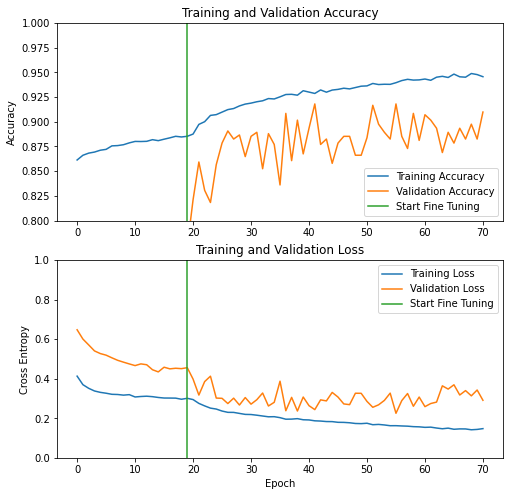

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [53]:
loss2, accuracy2 = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)
print("transfer learning loss: {:.2f}".format(loss2))
print("transfer learning accuracy: {:.2f}".format(accuracy2))

5/5 [==============================] - 1s 110ms/step - loss: 0.2650 - accuracy: 0.9062
transfer learning loss: 0.26
transfer learning accuracy: 0.91


## 9. Evaluation and Predictions

Finally, we can verify the performance of the model on new data using test set.

Predictions:
 [0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0]
Labels:
 [0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0]


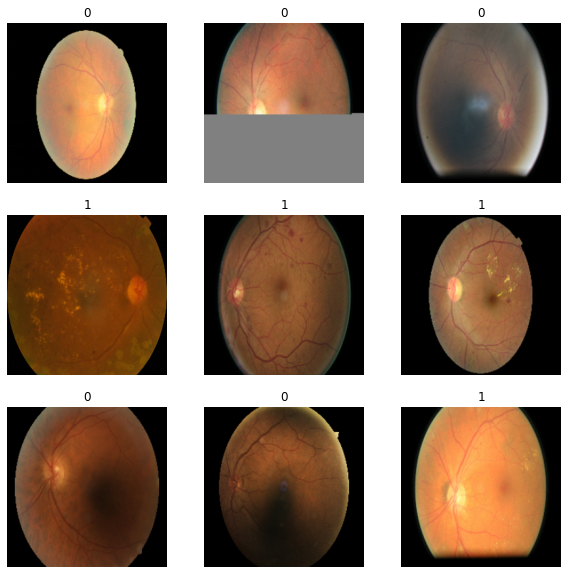

In [54]:
#Retrieve a batch of images from the test set
#first iteration - 90% - running predictions
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [55]:
from sklearn.metrics import classification_report #- take this

target_names = ['Healthy', 'Not Healthy']
print(classification_report(label_batch, predictions.numpy(), target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.95      0.95      0.95        19
 Not Healthy       0.92      0.92      0.92        13

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



Predictions:
 [1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Labels:
 [1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0]


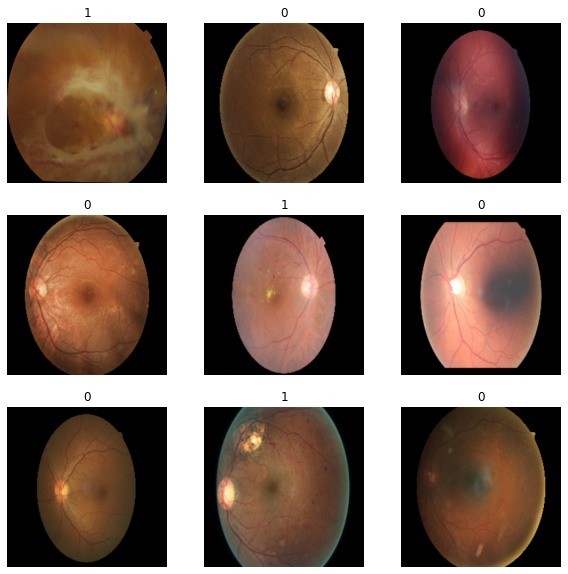

In [ ]:
#second iteration - 94% - running predictions
#Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

## 10. Save the model

Save the model for future predictions on test data. Used the 94% accuracy trained model for saving to drive.

In [57]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Capstone/TF_Model.hd5') - #2 days old
model.save('/content/drive/MyDrive/Colab Notebooks/Capstone/TF_Model1.hd5') #- today

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Capstone/TF_Model11.hd/assets


In [ ]:
#load model
from tensorflow.keras.models import load_model
tf_model = load_model('/content/drive/MyDrive/Colab Notebooks/Capstone/TF_Model.hd5')

## 11. Running additional experiment on epochs to determine if the accuracy improves.

In [58]:
# run second fine tune epochs
fine_tune_epochs2 = 80
total_epochs =  total_epochs + fine_tune_epochs2

history_fine2 = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_dataset)

Epoch 70/150
320/320 [==============================] - 36s 109ms/step - loss: 0.1368 - accuracy: 0.9483 - val_loss: 0.3033 - val_accuracy: 0.9057
Epoch 71/150
320/320 [==============================] - 36s 109ms/step - loss: 0.1378 - accuracy: 0.9468 - val_loss: 0.2871 - val_accuracy: 0.9044
Epoch 72/150
320/320 [==============================] - 36s 110ms/step - loss: 0.1363 - accuracy: 0.9499 - val_loss: 0.3457 - val_accuracy: 0.8798
Epoch 73/150
320/320 [==============================] - 36s 110ms/step - loss: 0.1370 - accuracy: 0.9491 - val_loss: 0.2866 - val_accuracy: 0.9085
Epoch 74/150
320/320 [==============================] - 36s 110ms/step - loss: 0.1359 - accuracy: 0.9481 - val_loss: 0.4093 - val_accuracy: 0.8730
Epoch 75/150
320/320 [==============================] - 36s 109ms/step - loss: 0.1329 - accuracy: 0.9496 - val_loss: 0.4335 - val_accuracy: 0.8784
Epoch 76/150
320/320 [==============================] - 36s 110ms/step - loss: 0.1378 - accuracy: 0.9478 - val_loss: 0

In [59]:
acc += history_fine2.history['accuracy']
val_acc += history_fine2.history['val_accuracy']

loss += history_fine2.history['loss']
val_loss += history_fine2.history['val_loss']

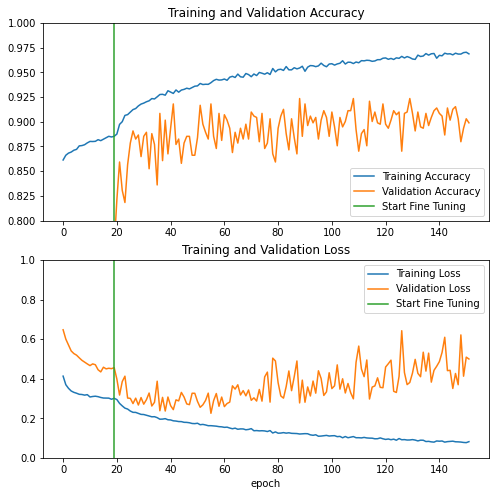

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
loss3, accuracy3 = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)
print("transfer learning loss at 150 epochs: {:.2f}".format(loss3))
print("transfer learning accuracy at 150 epochs: {:.2f}".format(accuracy3))

5/5 [==============================] - 1s 106ms/step - loss: 0.2423 - accuracy: 0.9438
transfer learning loss at 150 epochs: 0.24
transfer learning accuracy at 150 epochs: 0.94


Predictions:
 [1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1]
Labels:
 [1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1]


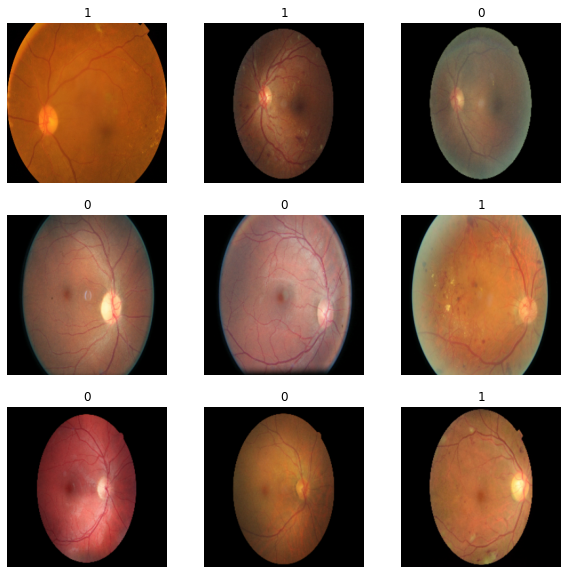

In [61]:
#second iteration - 94% - running predictions
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [62]:
print(classification_report(label_batch, predictions.numpy(), target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.87      1.00      0.93        20
 Not Healthy       1.00      0.75      0.86        12

    accuracy                           0.91        32
   macro avg       0.93      0.88      0.89        32
weighted avg       0.92      0.91      0.90        32



In [63]:
model.save('/content/drive/MyDrive/Colab Notebooks/Capstone/TF_Model2.hd5')
# model.save('/content/drive/MyDrive/Colab Notebooks/Capstone/TF_Model2.hd5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Capstone/TF_Model2.hd5/assets


## 12. Summary

### Using Pre-trained model:
When working with a small dataset, it is beneficial to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully connected classifier on top.
The pre-trained model is frozen and only the weights of the classifier get updated during training. The convolutional base extracted all the features associated with each image and just trained a classifier that determines the image class given that set of extracted features.

### Fine tuning a pre-train model:
To further improve performance, can repurpose the top-level layers of the pre-trained models to the new dataset via fine tuning. In this case, tuned weights such that model learned high-level features specific to the dataset.
